In [28]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
from cellpose import utils, io

# download noisy images from website
url = "http://www.cellpose.org/static/data/test_poisson.npz"
filename = "test_poisson.npz"
utils.download_url_to_file(url, filename)
dat = np.load(filename, allow_pickle=True)["arr_0"].item()

imgs = dat["test_noisy"]
plt.figure(figsize=(8,3))
for i, iex in enumerate([2, 18, 20]):
    img = imgs[iex].squeeze()
    plt.subplot(1,3,1+i)
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

  1%|          | 208k/28.0M [00:00<00:32, 886kB/s] 


KeyboardInterrupt: 

In [ ]:
from cellpose import models, io, plot
import tifffile
import numpy as np

# Load the actual image
image = tifffile.imread('/root/capsule/data/iGluSnFR_Soma_Annotation/721820_20240214_162524_DMD1_merged.tif')

# Load the labeled mask
mask = tifffile.imread('/root/capsule/data/iGluSnFR_Soma_Annotation/721820_20240214_162524_DMD1_1_segmented_v2.tif')

In [ ]:
image.shape

(21, 2, 800, 1280)

In [ ]:
# Convert to NumPy arrays if needed
images_raw = np.array([image])
image = images_raw[0, :, 0, :, :]
masks_raw = np.array([mask])
mask = masks_raw[0, :, :, :] 

In [ ]:
model = models.CellposeModel(gpu=True, model_type='cyto')

In [ ]:
from cellpose import train

train.train_seg(
    model.net,
    train_data=image,
    train_labels=mask,
    channels=[0, 0],  # Adjust channels if needed
    normalize=True,
    weight_decay=1e-4,
    SGD=False,
    learning_rate=0.1,
    n_epochs=1000,
    save_path='/root/capsule/scratch/adrian_cellpose/model',
    model_name='custom_cellpose_model.pth'
)

100%|██████████| 21/21 [00:00<00:00, 307.85it/s]
7 train images with number of masks less than min_train_masks (5), removing from train set
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


PosixPath('/root/capsule/scratch/adrian_cellpose/model/models/custom_cellpose_model.pth')

In [ ]:
masks_pred, flows, styles = model.eval(image, channels=[0, 0])

In [ ]:
masks_pred.shape, image[0].shape

((21, 800), (800, 1280))

ValueError: masks_to_outlines takes 2D or 3D array, not 1D array

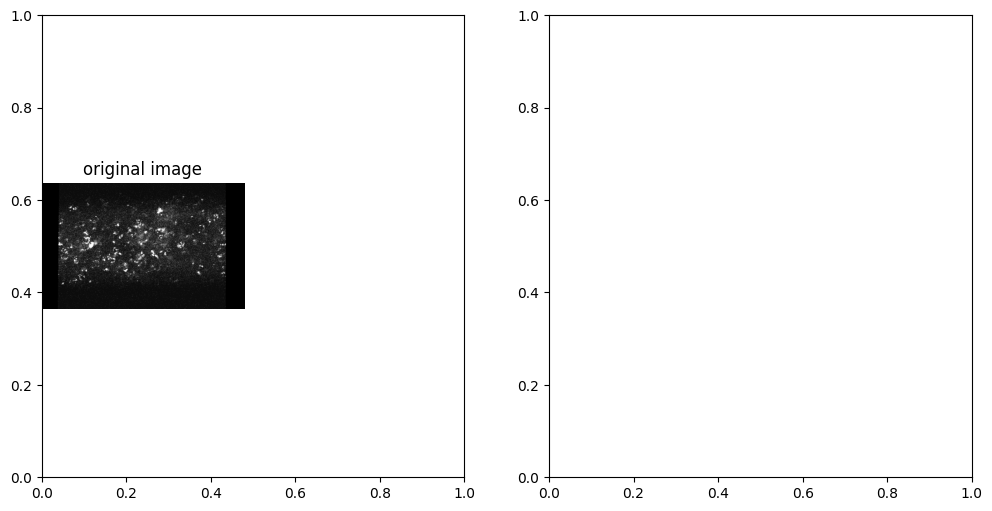

In [ ]:
# Visualize results for one of the test images
from cellpose import plot
import matplotlib.pyplot as plt

# Assuming test_images and masks_pred are 3D arrays (N_frames, height, width)
# Select the first frame for visualization
image_to_plot = image[0]  # Shape should be (height, width)
mask_to_plot = masks_pred[0]    # Shape should be (height, width)
flow_to_plot = flows[0]         # Shape should be (height, width, 2) for flow visualization

# Visualize the segmentation result
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot.show_segmentation(fig, image_to_plot, mask_to_plot, flow_to_plot, channels=[0, 0])
plt.show()

In [ ]:
image.shape, mask.shape

((21, 800, 1280), (21, 800, 1280))

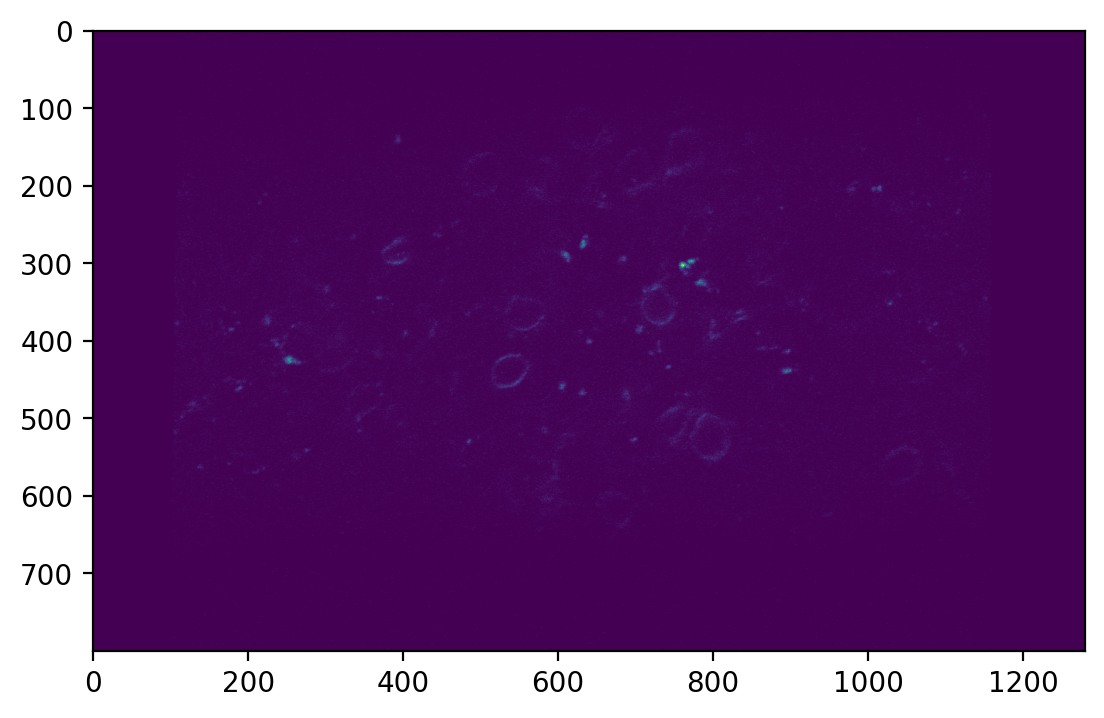

In [ ]:
plt.imshow(images[0,10,1,:,:])

In [ ]:
import os
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'
image_file = os.path.join(data_dir, 'your_image_file_merged.tif')
mask_file = os.path.join(data_dir, 'your_mask_file_segmented_v2.tif')

# Load data
images = tifffile.imread(image_file)  # Shape: (frames, height, width)
masks = tifffile.imread(mask_file)    # Shape: (frames, height, width)

# Ensure images and masks have the same number of frames
assert images.shape[0] == masks.shape[0], "Number of frames in images and masks must match."

# Split data into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type='cyto')

# Train the model
train.train_seg(
    model.net,
    train_data=train_images,
    train_labels=train_masks,
    channels=[0, 0],  # Adjust channels if needed
    normalize=True,
    weight_decay=1e-4,
    SGD=False,
    learning_rate=0.1,
    n_epochs=1000,
    save_path='/root/capsule/scratch/adrian_cellpose/model/models',
    model_name='custom_cellpose_model.pth'
)

# Evaluate the model on the test set
masks_pred, flows, styles, diams = model.eval(test_images, channels=[0, 0])

# Visualize results for one of the test images
from cellpose import plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot.show_segmentation(fig, test_images[0], masks_pred[0], flows[0], channels=[0, 0])
plt.show()

In [ ]:
import os
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img)) for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Split data into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type='cyto')

# Train the model
train.train_seg(
    model.net,
    train_data=train_images,
    train_labels=train_masks,
    channels=[0, 0],  # Adjust channels if needed
    normalize=True,
    weight_decay=1e-4,
    SGD=False,
    learning_rate=0.1,
    n_epochs=1000,
    save_path='/root/capsule/scratch/adrian_cellpose/model/models',
    model_name='custom_cellpose_model.pth'
)

 46%|████▋     | 62/134 [00:00<00:00, 303.29it/s]/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 134/134 [00:00<00:00, 301.32it/s]
25 train images with number of masks less than min_train_masks (5), removing from train set
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


PosixPath('/root/capsule/scratch/adrian_cellpose/model/models/models/custom_cellpose_model.pth')

3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only


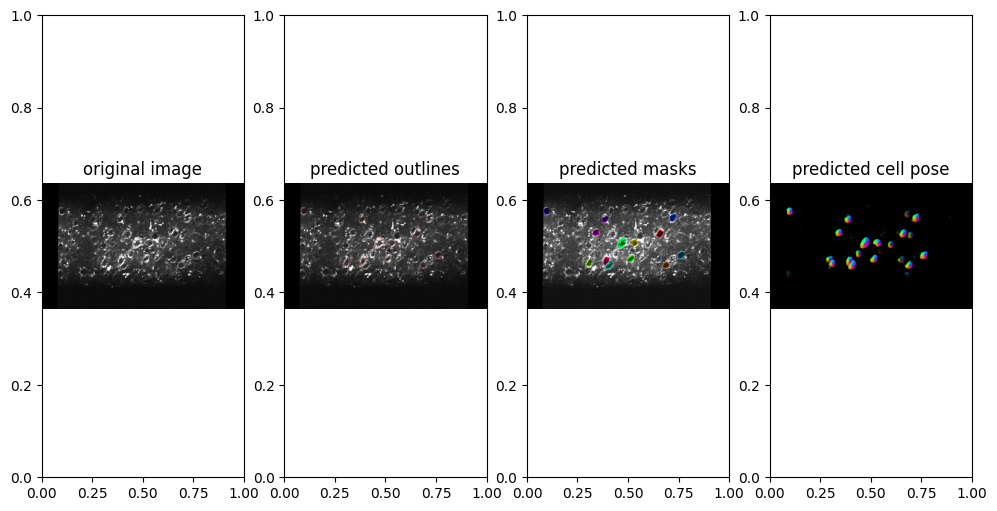

In [ ]:
# Evaluate the model on the test set
# Adjust unpacking based on the actual number of returned values
results = model.eval(test_images, channels=[0, 0])
if len(results) == 3:
    masks_pred, flows, styles = results
else:
    masks_pred, flows, styles, diams = results

# Visualize results for one of the test images
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
plot.show_segmentation(fig, test_images[0], masks_pred[0], flows[0][0], channels=[0, 0])
plt.show()

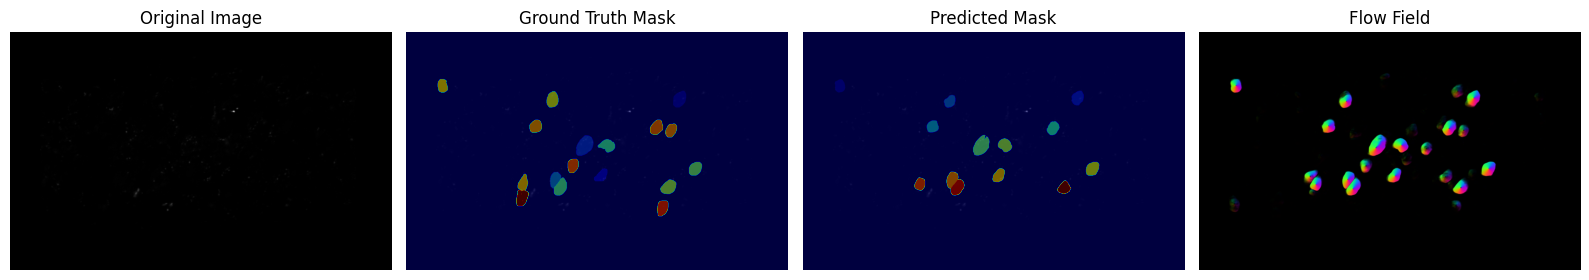

In [ ]:
# Visualize results for one of the test images
fig, ax = plt.subplots(1, 4, figsize=(16, 6))

# Original image
ax[0].imshow(test_images[0][0], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Ground truth mask
ax[1].imshow(test_images[0][0], cmap='gray')
ax[1].imshow(test_masks[0], cmap='jet', alpha=0.5)
ax[1].set_title('Ground Truth Mask')
ax[1].axis('off')

# Predicted mask
ax[2].imshow(test_images[0][0], cmap='gray')
ax[2].imshow(masks_pred[0], cmap='jet', alpha=0.5)
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

# Flow visualization
ax[3].imshow(flows[0][0], cmap='gray')
ax[3].set_title('Flow Field')
ax[3].axis('off')

plt.tight_layout()
plt.show()

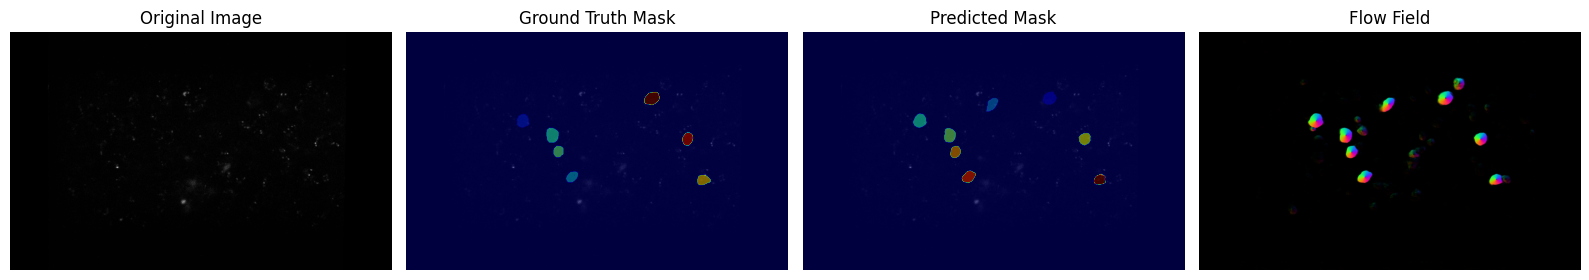

In [ ]:
# Visualize results for one of the test images
fig, ax = plt.subplots(1, 4, figsize=(16, 6))

# Original image
ax[0].imshow(test_images[1][0], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Ground truth mask 
ax[1].imshow(test_images[1][0], cmap='gray')
ax[1].imshow(test_masks[1], cmap='jet', alpha=0.5)
ax[1].set_title('Ground Truth Mask')
ax[1].axis('off')

# Predicted mask
ax[2].imshow(test_images[1][0], cmap='gray')
ax[2].imshow(masks_pred[1], cmap='jet', alpha=0.5)
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

# Flow visualization
ax[3].imshow(flows[0][1], cmap='gray')
ax[3].set_title('Flow Field')
ax[3].axis('off')

plt.tight_layout()
plt.show()

# Sanity check

In [ ]:
import os
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img)) for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

In [ ]:
images[0].shape

(21, 2, 800, 1280)

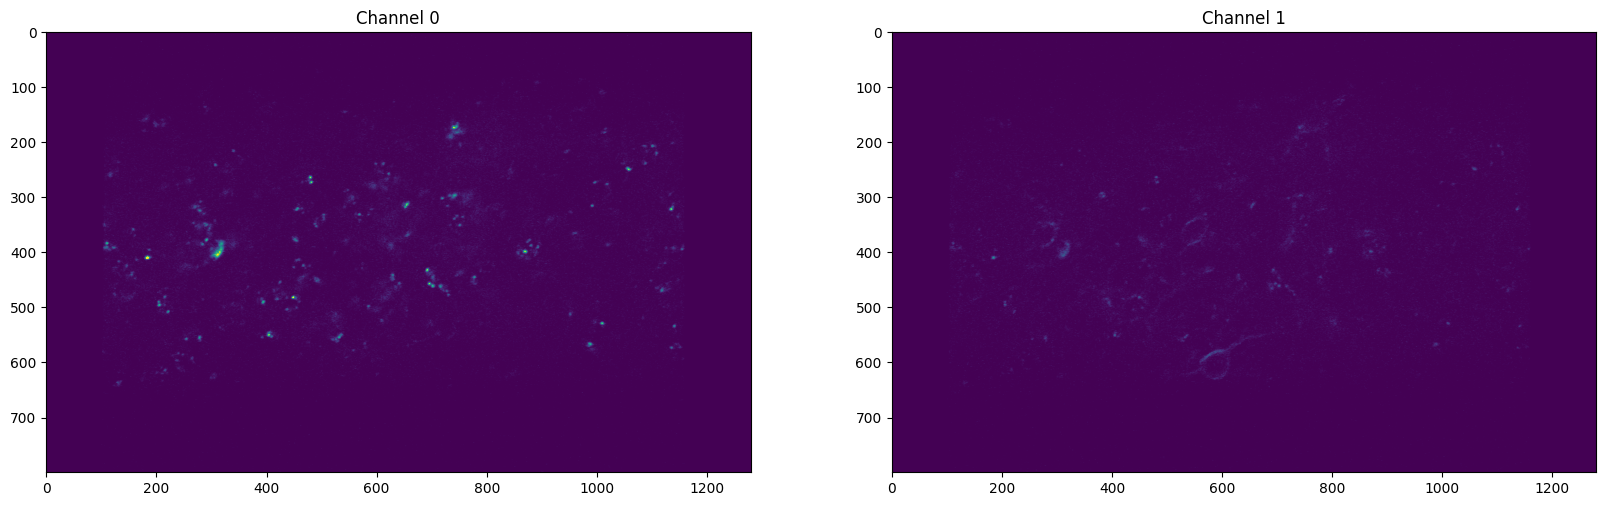

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Create a figure and a 1x2 subplot

# Plot the first image on the first subplot
im1 = axs[0].imshow(images[0][0,0,:,:])
axs[0].set_title('Channel 0')
im1.set_clim(0, 255)  # Set the color scale from 0 to 255

# Plot the second image on the second subplot
im2 = axs[1].imshow(images[0][0,1,:,:])
axs[1].set_title('Channel 1')
im2.set_clim(0, 255)  # Set the color scale from 0 to 255

plt.show()  # Display the figure with the subplots


In [ ]:
import numpy as np
import tifffile
import os

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Load and check masks
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(data_dir, mask_file))
    
    # Flatten the mask to a 1D array and find unique labels
    unique_labels = np.unique(mask)
    
    # Check if labels are continuous
    if not np.array_equal(unique_labels, np.arange(len(unique_labels))):
        print(f"Non-continuous labels found in {mask_file}: {unique_labels}")
    else:
        print(f"Labels in {mask_file} are continuous and unique.")

Non-continuous labels found in 721820_20240214_162524_DMD1_1_segmented_v2.tif: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19]
Labels in 721820_20240214_162524_DMD2_1_segmented_v2.tif are continuous and unique.
Labels in 725018_20240326_163614_DMD1_1_segmented_v2.tif are continuous and unique.
Labels in 725018_20240326_163614_DMD2_1_segmented_v2.tif are continuous and unique.
Labels in 725019_20240325_122809_DMD1_1_segmented_v2.tif are continuous and unique.
Labels in 725019_20240325_122809_DMD2_1_segmented_v2.tif are continuous and unique.
Labels in 725019_20240402_163502_DMD1_1_segmented_v2.tif are continuous and unique.
Labels in 725019_20240402_163502_DMD2_1_segmented_v2.tif are continuous and unique.


Non-continuous labels found in 721820_20240214_162524_DMD1_1_segmented_v2.tif: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19]


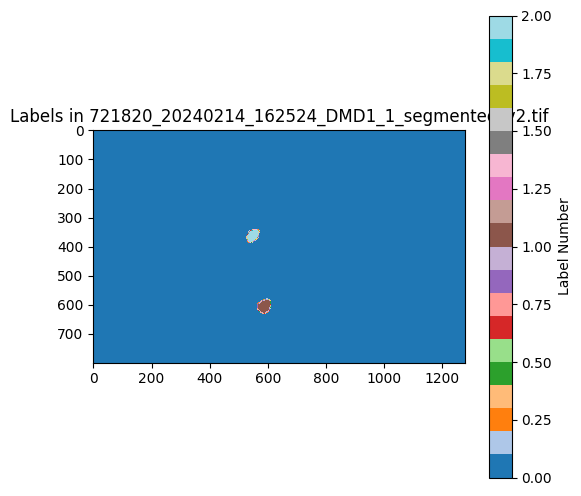

Labels in 721820_20240214_162524_DMD2_1_segmented_v2.tif are continuous and unique.
Labels in 725018_20240326_163614_DMD1_1_segmented_v2.tif are continuous and unique.
Labels in 725018_20240326_163614_DMD2_1_segmented_v2.tif are continuous and unique.
Labels in 725019_20240325_122809_DMD1_1_segmented_v2.tif are continuous and unique.
Labels in 725019_20240325_122809_DMD2_1_segmented_v2.tif are continuous and unique.
Labels in 725019_20240402_163502_DMD1_1_segmented_v2.tif are continuous and unique.
Labels in 725019_20240402_163502_DMD2_1_segmented_v2.tif are continuous and unique.


In [ ]:
import numpy as np
import tifffile
import os
import matplotlib.pyplot as plt

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Load and check masks
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(data_dir, mask_file))
    
    # Flatten the mask to a 1D array and find unique labels
    unique_labels = np.unique(mask)
    
    # Check if labels are continuous
    if not np.array_equal(unique_labels, np.arange(len(unique_labels))):
        print(f"Non-continuous labels found in {mask_file}: {unique_labels}")
        
        # Visualize the mask
        plt.figure(figsize=(6, 6))
        plt.imshow(mask[0], cmap='tab20')  # Use a colormap to distinguish labels
        plt.title(f"Labels in {mask_file}")
        plt.colorbar(label='Label Number')
        plt.show()
    else:
        print(f"Labels in {mask_file} are continuous and unique.")

In [ ]:
import numpy as np
import tifffile
import os
from collections import Counter

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Load and check masks
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(data_dir, mask_file))
    
    # Flatten the mask to a 1D array and find unique labels
    unique_labels = np.unique(mask)
    
    # Check if labels are continuous
    if not np.array_equal(unique_labels, np.arange(len(unique_labels))):
        print(f"Non-continuous labels found in {mask_file}: {unique_labels}")
    
    # Check for non-unique labels
    label_counts = Counter(mask.flatten())
    non_unique_labels = [label for label, count in label_counts.items() if count > 1]
    
    if len(non_unique_labels) != len(unique_labels):
        print(f"Non-unique labels found in {mask_file}: {non_unique_labels}")
        print(f'unique_labels', unique_labels)

Non-continuous labels found in 721820_20240214_162524_DMD1_1_segmented_v2.tif: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19]


In [ ]:
import numpy as np
import tifffile
import os
from collections import Counter

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Load and check masks
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(data_dir, mask_file))
    
    # Flatten the mask to a 1D array and count occurrences of each label
    label_counts = Counter(mask.flatten())
    
    # Print label counts
    print(f"Label counts in {mask_file}:")
    for label, count in label_counts.items():
        print(f"Label {label}: {count} times")

Label counts in 721820_20240214_162524_DMD1_1_segmented_v2.tif:
Label 0: 21292125 times
Label 2: 5781 times
Label 1: 11703 times
Label 3: 19393 times
Label 4: 15174 times
Label 9: 16198 times
Label 12: 12517 times
Label 7: 18591 times
Label 19: 9286 times
Label 18: 7552 times
Label 5: 12277 times
Label 13: 11253 times
Label 6: 11262 times
Label 8: 18884 times
Label 16: 10196 times
Label 10: 11371 times
Label 11: 12315 times
Label 14: 4195 times
Label 15: 3927 times
Label counts in 721820_20240214_162524_DMD2_1_segmented_v2.tif:
Label 0: 21315771 times
Label 3: 11238 times
Label 1: 10240 times
Label 7: 13377 times
Label 14: 10909 times
Label 6: 9633 times
Label 17: 7365 times
Label 5: 8206 times
Label 2: 10701 times
Label 4: 12031 times
Label 13: 17792 times
Label 12: 12427 times
Label 9: 15955 times
Label 8: 21448 times
Label 15: 5169 times
Label 11: 8947 times
Label 16: 5811 times
Label 10: 6980 times
Label counts in 725018_20240326_163614_DMD1_1_segmented_v2.tif:
Label 0: 20949503 ti

# Data augmentation and extras

In [1]:
import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Split data into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# # Convert masks to uint8
# train_masks_uint8 = [msk.astype(np.uint8) for msk in train_masks]

# # Resize images and masks to a common size
# common_size = (1280, 800)  # Define a common size

# resized_images = [cv2.resize(img, common_size) for img in train_images]
# resized_masks = [cv2.resize(msk, common_size, interpolation=cv2.INTER_NEAREST) for msk in train_masks_uint8]

# # Convert lists to numpy arrays
# train_images = np.array(resized_images)
# train_masks = np.array(resized_masks)

# Convert test masks to uint8 before resizing
# test_masks_uint8 = [msk.astype(np.uint8) for msk in test_masks]

# # Resize test images and masks to the common size
# resized_test_images = [cv2.resize(img, common_size) for img in test_images]
# resized_test_masks = [cv2.resize(msk, common_size, interpolation=cv2.INTER_NEAREST) for msk in test_masks_uint8]

# # Convert lists to numpy arrays
# test_images = np.array(resized_test_images)
# test_masks = np.array(resized_test_masks)

# Define an augmentation  pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Horizontal flip with a 50% probability
    A.VerticalFlip(p=0.5),    # Vertical flip with a 50% probability
    A.Rotate(limit=45, p=0.5),  # Random rotation within a range of -45 to 45 degrees with a 50% probability
    # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastic deformation with specified parameters
], is_check_shapes=False)

augmented_images = []
augmented_masks = []

for img, msk in zip(train_images, train_masks):
    # Apply the augmentation pipeline
    transformed = transform(image=img, mask=msk)
    augmented_images.append(transformed['image'])
    augmented_masks.append(transformed['mask'])

# Convert lists to numpy arrays
train_images = np.array(augmented_images)

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type='cyto')

# Train the model with augmented data
train.train_seg(
    model.net,
    train_data=train_images,
    train_labels=train_masks,
    channels=[0, 0],  # Adjust channels if needed
    normalize=True,
    weight_decay=1e-4,
    SGD=False,
    learning_rate=0.1,
    n_epochs=1000,
    save_path='/root/capsule/scratch/adrian_cellpose/model/models',
    model_name='custom_cellpose_model.pth'
)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'warpAffine'
> Overload resolution failed:
>  - src data type = uint32 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


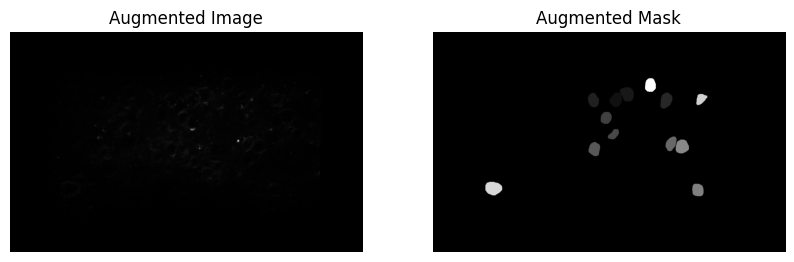

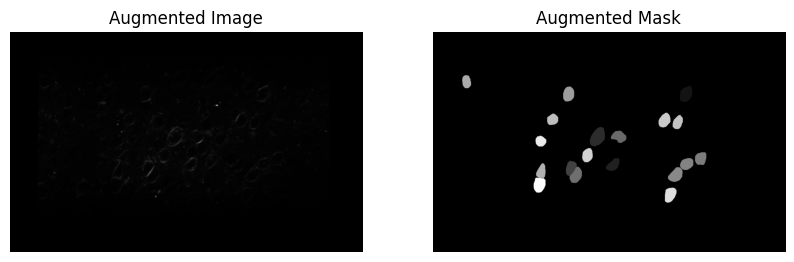

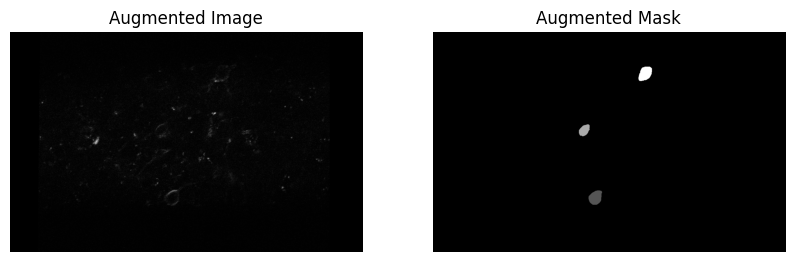

 15%|█▍        | 117/804 [00:06<00:30, 22.64it/s]empty masks!
empty masks!
 69%|██████▊   | 552/804 [00:34<00:23, 10.64it/s]empty masks!
empty masks!
empty masks!
 69%|██████▉   | 557/804 [00:34<00:14, 16.60it/s]empty masks!
empty masks!
 71%|███████   | 572/804 [00:35<00:14, 16.28it/s]empty masks!
empty masks!
empty masks!
empty masks!
 90%|█████████ | 724/804 [00:45<00:06, 12.93it/s]empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
 91%|█████████▏| 734/804 [00:45<00:03, 19.09it/s]empty masks!
empty masks!
empty masks!
empty masks!
empty masks!
  8%|▊         | 66/804 [00:00<00:03, 217.73it/s]/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 804/804 [00:03<00:00, 217.56it/s]
150 train

PosixPath('/root/capsule/scratch/adrian_cellpose/model/models/models/custom_cellpose_model.pth')

In [1]:
import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Split data into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Normalize images to 0-1 range
train_images = [img.astype(np.float32) / 255.0 for img in train_images]
test_images = [img.astype(np.float32) / 255.0 for img in test_images]

# Convert masks to uint8 if needed
train_masks_uint8 = [msk.astype(np.uint8) for msk in train_masks]

# Resize images and masks to a common size
common_size = (1280, 800)  # Define a common size

resized_images = [cv2.resize(img, common_size) for img in train_images]
resized_masks = [cv2.resize(msk, common_size, interpolation=cv2.INTER_NEAREST) for msk in train_masks_uint8]

# Convert lists to numpy arrays
train_images = np.array(resized_images)
train_masks = np.array(resized_masks)

# Convert test masks to uint8 before resizing
test_masks_uint8 = [msk.astype(np.uint8) for msk in test_masks]

# Resize test images and masks to the common size
resized_test_images = [cv2.resize(img, common_size) for img in test_images]
resized_test_masks = [cv2.resize(msk, common_size, interpolation=cv2.INTER_NEAREST) for msk in test_masks_uint8]

# Convert lists to numpy arrays
test_images = np.array(resized_test_images)
test_masks = np.array(resized_test_masks)

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
], is_check_shapes=False)

augmented_images = []
augmented_masks = []

# Augment each image multiple times
num_augmentations = 5  # Number of times to augment each image

for img, msk in zip(train_images, train_masks):
    for _ in range(num_augmentations):
        # Apply the augmentation pipeline
        transformed = transform(image=img, mask=msk)
        augmented_images.append(transformed['image'])
        augmented_masks.append(transformed['mask'])

# Convert lists to numpy arrays and combine with original data
train_images_augmented = np.array(augmented_images)
train_masks_augmented = np.array(augmented_masks)

# Combine original and augmented data
train_images_combined = np.concatenate((train_images, train_images_augmented), axis=0)
train_masks_combined = np.concatenate((train_masks, train_masks_augmented), axis=0)

# Visualize to check
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(train_images_combined[i], cmap='gray')
    plt.title('Augmented Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(train_masks_combined[i], cmap='gray')
    plt.title('Augmented Mask')
    plt.axis('off')

    plt.show()

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type='cyto')

# Train the model with augmented data
train.train_seg(
    model.net,
    train_data=train_images_combined,
    train_labels=train_masks_combined,
    channels=[0, 0],  # Adjust channels if needed
    normalize=True,
    weight_decay=1e-4,
    SGD=False,
    learning_rate=0.1,
    n_epochs=1000,
    save_path='/root/capsule/scratch/adrian_cellpose/model/models',
    model_name='custom_cellpose_model.pth'
)

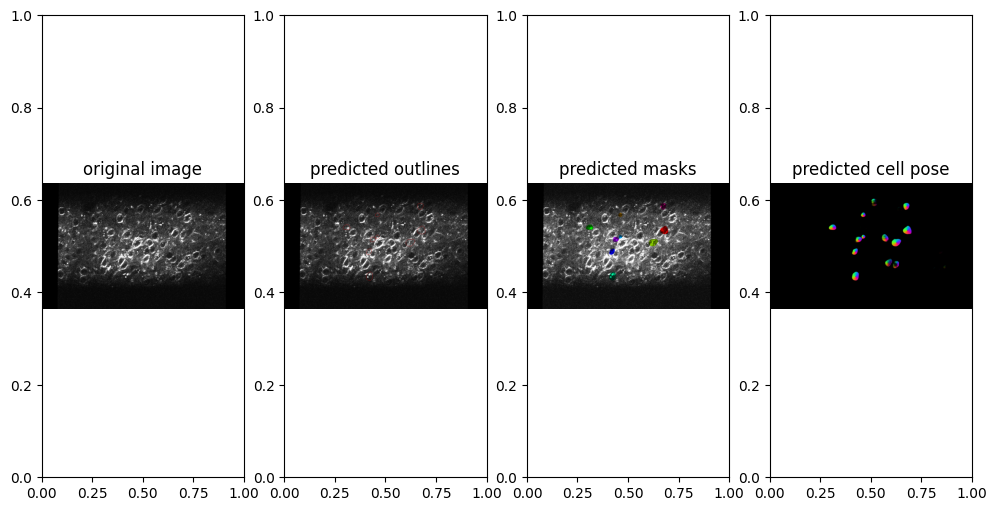

In [2]:
# Evaluate the model on the test set
# Adjust unpacking based on the actual number of returned values
results = model.eval(test_images[10], channels=[0, 0])
if len(results) == 3:
    masks_pred, flows, styles = results
else:
    masks_pred, flows, styles, diams = results

# Visualize results for one of the test images
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
plot.show_segmentation(fig, test_images[0], masks_pred, flows[0], channels=[0, 0])
plt.show()

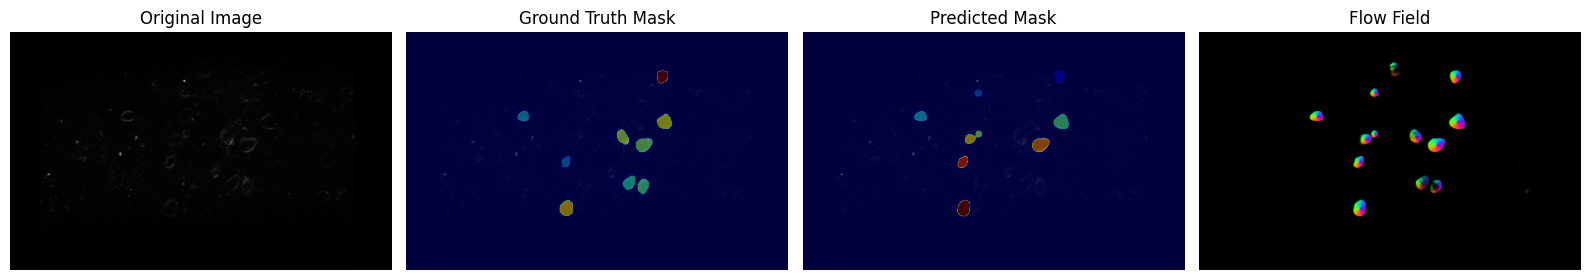

In [3]:
# Visualize results for one of the test images
fig, ax = plt.subplots(1, 4, figsize=(16, 6))

# Original image
ax[0].imshow(test_images[10], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Ground truth mask 
ax[1].imshow(test_images[10], cmap='gray')
ax[1].imshow(test_masks[10], cmap='jet', alpha=0.5)
ax[1].set_title('Ground Truth Mask')
ax[1].axis('off')

# Predicted mask
ax[2].imshow(test_images[10], cmap='gray')
ax[2].imshow(masks_pred, cmap='jet', alpha=0.5)
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

# Flow visualization
ax[3].imshow(flows[0], cmap='gray')
ax[3].set_title('Flow Field')
ax[3].axis('off')

plt.tight_layout()
plt.show()

In [9]:
image.shape

(800, 1280)

In [10]:
import pandas as pd
from cellpose import metrics

# Prepare a DataFrame to store the results
results_df = pd.DataFrame(columns=[
    'Image_Index', 'Aggregated_Jaccard_Index', 'Average_Precision_0.5', 
    'Average_Precision_0.75', 'Average_Precision_0.9', 'Boundary_Precision', 
    'Boundary_Recall', 'Boundary_F_Score', 'Flow_Error', 'Mask_IOUs'
])

# Define scales for boundary scores (example values)
scales = [1, 2, 4]

# Loop through all test images
for i, (image, true_mask) in enumerate(zip(test_images, test_masks)):
    # Evaluate the model on the test image
    results = model.eval(image, channels=[0, 0])
    if len(results) == 3:
        masks_pred, flows, styles = results
    else:
        masks_pred, flows, styles, diams = results

    # Compute metrics
    aji = metrics.aggregated_jaccard_index(true_mask, masks_pred)
    ap, _, _, _ = metrics.average_precision(true_mask, masks_pred, threshold=[0.5, 0.75, 0.9])
    print('AP---->', ap)
    bp, br, bf = metrics.boundary_scores(true_mask, masks_pred, scales)
    flow_error = metrics.flow_error(true_mask, flows[0], device=None)
    ious = metrics.mask_ious(true_mask, masks_pred)

    # Append results to DataFrame
    results_df = results_df.append({
        'Image_Index': i,
        'Aggregated_Jaccard_Index': aji,
        'Average_Precision_0.5': ap[0],
        'Average_Precision_0.75': ap[1],
        'Average_Precision_0.9': ap[2],
        'Boundary_Precision': bp,
        'Boundary_Recall': br,
        'Boundary_F_Score': bf,
        'Flow_Error': flow_error,
        'Mask_IOUs': np.mean(ious)  # Store mean IOU for simplicity
    }, ignore_index=True)

# Save results to a CSV file
results_df.to_csv('/root/capsule/scratch/adrian_cellpose/evaluation_results.csv', index=False)

AP----> [0.3846154  0.3846154  0.22727273]


/opt/conda/lib/python3.10/site-packages/cellpose/metrics.py:78: RuntimeWarning: invalid value encountered in divide
  aji[n] = overlap.sum() / union
/opt/conda/lib/python3.10/site-packages/cellpose/metrics.py:196: RuntimeWarning: invalid value encountered in divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: masks_to_outlines takes 2D or 3D array, not 1D array

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import jaccard_score
from cellpose import models, plot
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tifffile
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

# Define custom dataset class
class CellposeDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)  # Convert image to uint8
        mask = self.masks[idx].astype(np.uint8)    # Convert mask to uint8
        
        # Ensure image and mask have the same shape
        if image.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        return image, mask

# Define data augmentation pipeline
def apply_data_augmentation(image, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        ToTensorV2()
    ])
    
    transformed = transform(image=image, mask=mask)
    return transformed['image'], transformed['mask']

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img)) for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Split data into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Create dataset and data loader
dataset = CellposeDataset(train_images, train_masks, transform=apply_data_augmentation)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# List of model types to try
model_types = ['cyto3', 'nuclei', 'cyto2', 'cyto', 'tissuenet_cp3', 'livecell_cp3']

# Loop over each model type
for model_type in model_types:
    # Initialize Cellpose model
    model = models.CellposeModel(gpu=True, model_type=model_type)

    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.net.parameters(), lr=0.1)

    # Define learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=0.001)

    # Train the model
    for epoch in range(1000):
        model.net.train()
        total_loss = 0
        for batch in data_loader:
            images, masks = batch
            images = torch.stack(images).float()
            masks = torch.stack(masks).long()
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model.net(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update total loss
            total_loss += loss.item()
        
        # Calculate validation loss, DICE score, and IOU
        model.net.eval()
        with torch.no_grad():
            val_loss = 0
            dice_scores = []
            iou_scores = []
            for batch in data_loader:
                images, masks = batch
                images = torch.stack(images).float()
                masks = torch.stack(masks).long()
                
                # Forward pass
                outputs = model.net(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Calculate DICE score and IOU
                preds = torch.argmax(outputs, dim=1)
                dice_scores.extend([jaccard_score(pred.cpu().numpy().flatten(), mask.cpu().numpy().flatten(), average='binary') for pred, mask in zip(preds, masks)])
                iou_scores.extend([jaccard_score(pred.cpu().numpy().flatten(), mask.cpu().numpy().flatten(), average='binary') for pred, mask in zip(preds, masks)])
            
            # Update learning rate
            scheduler.step(val_loss / len(data_loader))
            
            # Log results
            with open('results.csv', 'a') as f:
                f.write(f'Model Type: {model_type}, Epoch: {epoch+1}, Train Loss: {total_loss / len(data_loader)}, Val Loss: {val_loss / len(data_loader)}, DICE Score: {np.mean(dice_scores)}, IOU: {np.mean(iou_scores)}, Learning Rate: {optimizer.param_groups[0]["lr"]}\n')

# Visualization example
# Assuming you have a test image and mask to visualize
test_image = test_images[0]
test_mask = test_masks[0]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot.show_segmentation(fig, test_image, test_mask, None, channels=[0, 0])
plt.show()

TypeError: tuple indices must be integers or slices, not str